[*********************100%***********************]  1 of 1 completed
C:\Users\nilee\AppData\Local\Temp\ipykernel_11460\3080264839.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_cad.rename(columns={'Adj Close': 'usd_cad'}, inplace=True)
[*********************100%***********************]  1 of 1 completed
C:\Users\nilee\AppData\Local\Temp\ipykernel_11460\3080264839.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_data.rename(columns={'Adj Close': 'WTI Oil'}, inplace=True)


            usd_cad    WTI Oil
Date                          
2015-01-02  1.16140  52.689999
2015-01-05  1.17930  50.040001
2015-01-06  1.17570  47.930000
2015-01-07  1.18370  48.650002
2015-01-08  1.18185  48.790001


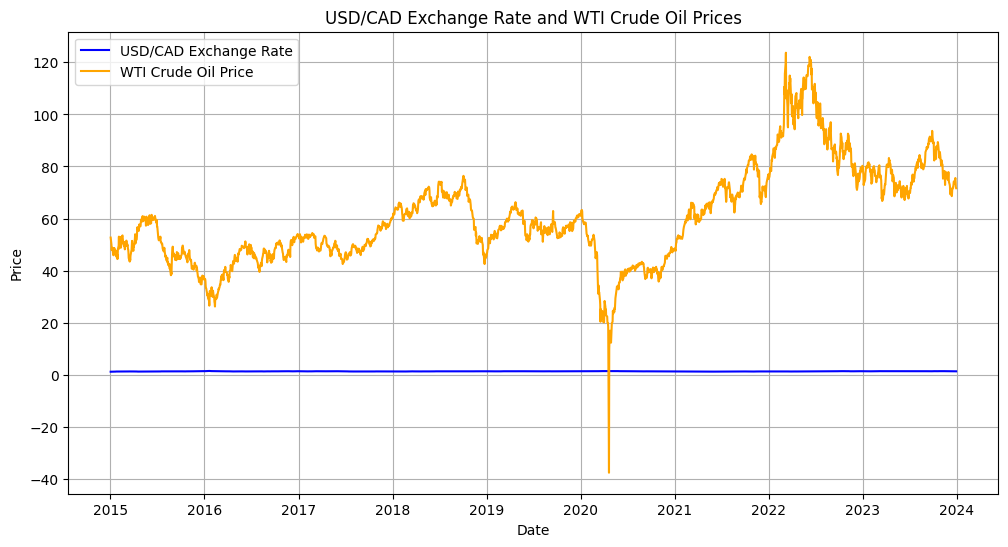

In [1]:
from fredapi import Fred
import requests
import pandas as pd
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fetch USD/CAD exchange rate data using yfinance
def get_usd_cad_data_yf():
    # Fetching the USD/CAD exchange rate data using ticker symbol "CAD=X"
    usd_cad = yf.download("CAD=X", start="2015-01-01", end="2024-01-01")
    # Adjusting the dataframe to keep only the adjusted close prices
    usd_cad = usd_cad[['Adj Close']]
    usd_cad.rename(columns={'Adj Close': 'usd_cad'}, inplace=True)
    return usd_cad

# Step 2: Fetch WTI crude oil price data using yfinance
def get_oil_data_yf():
    # Fetching the WTI crude oil price data using ticker symbol "CL=F"
    oil_data = yf.download("CL=F", start="2015-01-01", end="2024-01-01")
    # Adjusting the dataframe to keep only the adjusted close prices
    oil_data = oil_data[['Adj Close']]
    oil_data.rename(columns={'Adj Close': 'WTI Oil'}, inplace=True)
    return oil_data

# Fetch data
usd_cad_data_yf = get_usd_cad_data_yf()
oil_prices_yf = get_oil_data_yf()

# Merge both datasets on date
data = usd_cad_data_yf.merge(oil_prices_yf, left_index=True, right_index=True, how='inner')

# Display the first few rows
print(data.head())

# Plot USD/CAD and WTI Oil prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['usd_cad'], label='USD/CAD Exchange Rate', color='blue')
plt.plot(data.index, data['WTI Oil'], label='WTI Crude Oil Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('USD/CAD Exchange Rate and WTI Crude Oil Prices')
plt.legend()
plt.grid()
plt.show()

In [2]:
import numpy as np
# Step 3: Calculate moving averages
data['SMA20'] = data['usd_cad'].rolling(window=20).mean()
data['SMA50'] = data['usd_cad'].rolling(window=50).mean()

# Generate signals
data['Signal'] = 0
data['Signal'][20:] = np.where(data['SMA20'][20:] > data['SMA50'][20:], 1, -1)  # 1 for buy, -1 for sell


C:\Users\nilee\AppData\Local\Temp\ipykernel_11460\3575818809.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][20:] = np.where(data['SMA20'][20:] > data['SMA50'][20:], 1, -1)  # 1 for buy, -1 for sell
C:\Users\nilee\AppData\

In [3]:
data

,usd_cad,WTI Oil,SMA20,SMA50,Signal
Date,,,,,
2015-01-02,1.16140,52.689999,NaN,NaN,0
2015-01-05,1.17930,50.040001,NaN,NaN,0
2015-01-06,1.17570,47.930000,NaN,NaN,0
2015-01-07,1.18370,48.650002,NaN,NaN,0
2015-01-08,1.18185,48.790001,NaN,NaN,0
...,...,...,...,...,...
2023-12-22,1.32839,73.559998,1.350854,1.364793,-1
2023-12-26,1.32500,75.570000,1.348952,1.363925,-1
2023-12-27,1.31952,74.110001,1.346893,1.363027,-1


In [4]:
# Step 4: Adjust signals based on oil price trend
data['Oil_Change'] = data['WTI Oil'].pct_change()

# If oil price is rising and we have a buy signal, reduce the position (CAD is strengthening)
data['Adjusted_Signal'] = data['Signal']
data.loc[data['Oil_Change'] > 0, 'Adjusted_Signal'] = data['Signal'] * 0.5  # Reduce exposure when oil prices rise

C:\Users\nilee\AppData\Local\Temp\ipykernel_11460\1781668835.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.   0.   0.  ... -0.5 -0.5 -0.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Oil_Change'] > 0, 'Adjusted_Signal'] = data['Signal'] * 0.5  # Reduce exposure when oil prices rise


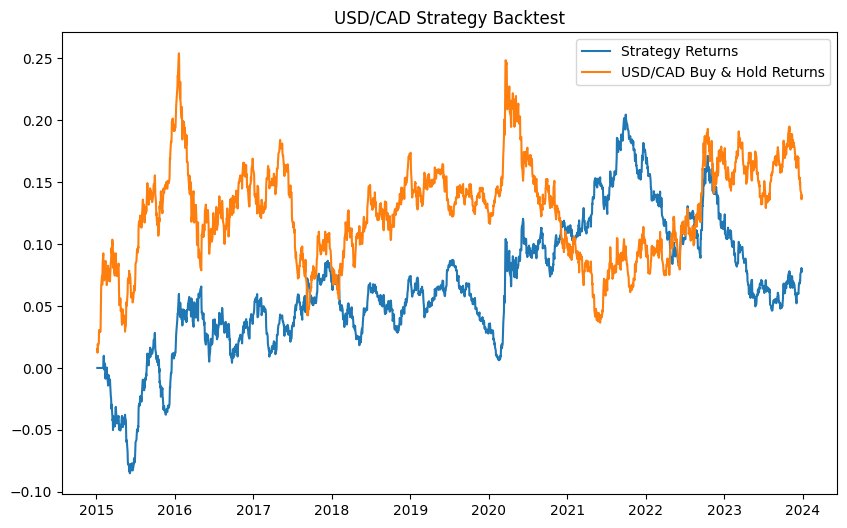

In [10]:
# Step 5: Calculate returns
data['USD/CAD Returns'] = data['usd_cad'].pct_change()
data['Strategy_Returns'] = data['USD/CAD Returns'] * data['Adjusted_Signal'].shift(1)

# Step 6: Backtest performance
cumulative_returns = (1 + data['Strategy_Returns']).cumprod() - 1

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Strategy Returns")
plt.plot((1 + data['USD/CAD Returns']).cumprod() - 1, label="USD/CAD Buy & Hold Returns")
plt.title("USD/CAD Strategy Backtest")
plt.legend()
plt.show()

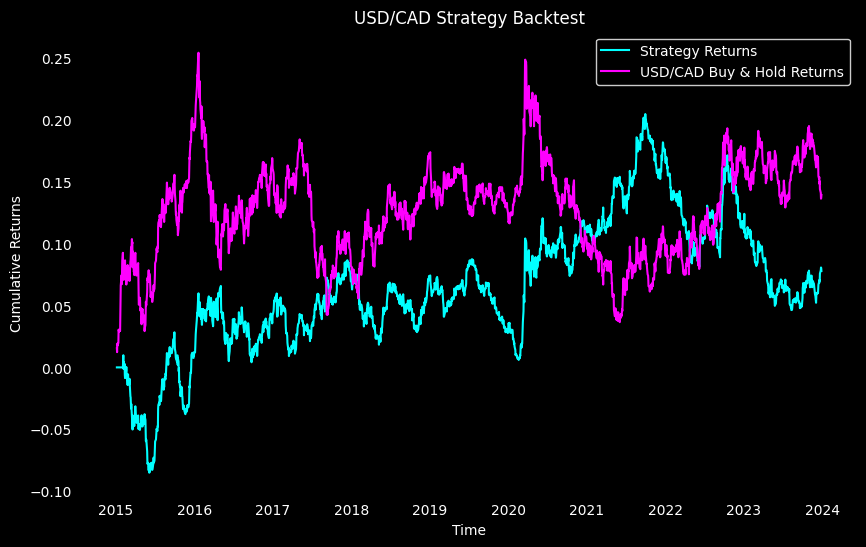

In [9]:
import matplotlib.pyplot as plt

# Plot the performance with a black background
plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('black')  # Set the background of the plot area to black
plt.gcf().patch.set_facecolor('black')  # Set the figure background to black

# Plotting the strategy and buy & hold returns
plt.plot(cumulative_returns, label="Strategy Returns", color='cyan')  # Change line color for better visibility
plt.plot((1 + data['USD/CAD Returns']).cumprod() - 1, label="USD/CAD Buy & Hold Returns", color='magenta')

# Set the title, legend, and other elements with customized color
plt.title("USD/CAD Strategy Backtest", color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.xlabel("Time", color='white')
plt.ylabel("Cumulative Returns", color='white')

# Set the color of the ticks
plt.xticks(color='white')
plt.yticks(color='white')

# Show the plot
plt.show()